# Corpus from OpenRefine

The notebook download and merge all the sources tagged with #corpusVC in OpenRefine 

In [1]:
import pandas as pd
import os
import time
import glob
import requests
from tqdm import tqdm
import datetime
import plotly.express as px
import shutil

## Step 1. Create folder for the process

In [2]:
# Get the current date in "YYYY-MM-DD" format
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# Define the folder name based on the current date
folder_name = f"data_OR_{current_date}"

# Get the script's directory (where this code is executed)
script_directory = os.getcwd()

# Create the full path for the new folder in the script's directory
folder_path = os.path.join(script_directory, folder_name)

# Check if the folder already exists and create it if not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_name}' created in '{script_directory}'")
else:
    print(f"Folder '{folder_name}' already exists in '{script_directory}'")

Folder 'data_OR_2023-11-06' created in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local'


## Step 2. Download datasets

### Step 2.1 LOC

#### Online

In [3]:
# Define the URL of the file to download
file_url = 'https://jdp.visualcontagions.net/data/loc.csv'

In [4]:
# Extract the file name from the URL
file_name = os.path.basename(file_url)
file_path = os.path.join(folder_path, file_name)

# Stream the file download with a progress bar
response = requests.get(file_url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Get the total file size (in bytes)
    total_size = int(response.headers.get('content-length', 0))

    # Create a progress bar using tqdm
    progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

    # Open a file for writing
    with open(file_path, 'wb') as file:
        for data in response.iter_content(chunk_size=1024):
            # Write the downloaded data to the file
            file.write(data)

            # Update the progress bar
            progress_bar.update(len(data))

    # Close the progress bar
    progress_bar.close()

    print(f"File '{file_name}' downloaded and saved in '{folder_path}'")
else:
    # Handle errors
    print(f"Download failed with status code {response.status_code}")


100%|██████████| 504M/504M [01:10<00:00, 7.19MB/s] 

File 'loc.csv' downloaded and saved in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-09-22'


#### Local

In [5]:
loc_source_file = "/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/LOC/LOC.csv"
shutil.move(loc_source_file, folder_path)

Error: Destination path '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-11-06/LOC.csv' already exists

### Step 2.2. Everything Else

**List of the projects from OpenRefine**

In [6]:
# Define the API endpoint URL
api_url = 'http://129.194.213.75/command/core/get-all-project-metadata'

# Disable SSL certificate verification (use with caution)
verify_ssl = False

# Make the GET request to the API
response = requests.get(api_url, verify=verify_ssl)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    api_response = response.json()
else:
    print(f"API request failed with status code: {response.status_code}")
    print(response.text)

projects_data = api_response.get('projects', {})

# Initialize an empty dictionary for projects
projects_dict = {}

# Iterate through the projects
for project_id, project_info in projects_data.items():
    project_tags = project_info.get('tags', [])
    if 'corpusVC' in project_tags:
        project_name = project_info.get('name', '')
        projects_dict[project_id] = project_name

print(projects_dict)

{'2446635959543': 'Chile 2023 iiif', '2141702759150': "L'artiste", '1897293512341': 'BNF_periodic_1', '1688128007940': 'Journaux Est-Asiatique (collecte barbara)', '1914921870678': 'Adrien iaddb data iiif(UNIGE)', '1695103319397': 'AG2023', '1878246014108': 'Backup_2022_02_03_PDF_cleaned', '2564230951744': 'Brasilian Source Raoul', '1695291554765': 'Marie mag PhD data iiif (UNIGE)', '2330813936766': 'art mode', '2444543925027': 'zenith', '2010224589348': 'Der Spiegel', '1929627493981': 'Project Translatio', '2637062031927': 'Slovenia magazines with iiif manifest csv', '2292433354811': 'Le Magasin pittoresque', '2216922237200': 'La Locomotion automobile', '2374512373252': 'BackupCBT_2022_02_03_IIIF', '2332878816656': 'digiteca', '1792589433060': 'BNF_periodics_2_2023', '2332843665824': 'Princeton Blue Mountain', '2370932517189': 'AG2023_part2', '2090209062960': 'National Geographic with iiif manifest'}


In [7]:
# Define the API endpoint and parameters
url = 'http://129.194.213.75/command/core/export-rows'
format = 'csv'
engine = '{"facets":[],"mode":"row-based"}'

# Dictionary of project IDs to project names

# the folder is already specified in step 1
#folder_path = 'project_refine'

# Iterate over the projects and their names
for project_id, project_name in projects_dict.items():
    # Set the project parameter
    params = {
        'project': project_id,
        'format': format,
        'engine': engine
    }

    # Specify the file name for each project
    file_name = f'{project_name}.csv'
    file_path = os.path.join(folder_path, file_name)

    # Send the POST request
    response = requests.post(url, params=params)

    # Check the response status and save the CSV data to a file
    if response.status_code == 200:
        # The request was successful, save the CSV data to the file
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"CSV data for '{project_name}' (ID: {project_id}) saved as '{file_name}' in '{folder_path}'")
    else:
        # Handle errors
        print(f"Request for '{project_name}' (ID: {project_id}) failed with status code {response.status_code}")
        print(response.text)


CSV data for 'Chile 2023 iiif' (ID: 2446635959543) saved as 'Chile 2023 iiif.csv' in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-11-06'
CSV data for 'L'artiste' (ID: 2141702759150) saved as 'L'artiste.csv' in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-11-06'
CSV data for 'BNF_periodic_1' (ID: 1897293512341) saved as 'BNF_periodic_1.csv' in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-11-06'
CSV data for 'Journaux Est-Asiatique (collecte barbara)' (ID: 1688128007940) saved as 'Journaux Est-Asiatique (collecte barbara).csv' in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-11-06'
CSV data for 'Adrien iaddb data iiif(UNIGE)' (ID: 1914921870678) saved as 'Adrien iaddb data iiif(UNIGE).csv' in '/Users/carboni/Documents/UNIGE/pynotebook/OpenRefine_fusion_Local/data_OR_2023-11-06'
CSV data for 'AG2023' (ID: 1695103319397) saved as 'AG2023.csv' in '/Users

## Step 3. Merge and Analyse

In [8]:
keep_col = ['Media URL','City','Country','wkt', 'normalized_date', 'Title', 'Journal Type']

In [9]:
# List all CSV files in the folder
all_files = glob.glob(folder_path + "/*.csv")

# Iterate over the files and delete those with 'CorpusCombined' in the filename
for filename in all_files:
    if 'CorpusCombined' in filename:
        os.remove(filename)
        print(f"Deleted '{filename}'")

### Step 3.1 Create 2 datasets, one with LOC and one without

In [10]:
#with LOC

all_files = glob.glob(folder_path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter=',', low_memory=False)
    df = df[keep_col]
    df['source'] = filename.split("/")[-1]
    li.append(df)

df_merged = pd.concat(li, axis=0, ignore_index=True)

In [16]:
#without LOC + sources

all_files = glob.glob(folder_path + "/*.csv")
li = []

for filename in all_files:
    # Skip processing 'loc.csv'
    if 'loc.csv' in filename:
        continue    
    df = pd.read_csv(filename, index_col=None, header=0, delimiter=',', low_memory=False)    
    df = df[keep_col]   
    df['source'] = filename.split("/")[-1]
    li.append(df)
    
df_merged_sans_loc = pd.concat(li, axis=0, ignore_index=True)

In [8]:
df_merged_sans_loc.to_csv('combined.csv', index=False)

In [10]:
combined_light = df_merged_sans_loc.drop_duplicates(subset='Title', keep="first")

In [11]:
combined_light.to_csv('combined_light.csv', index=False)

In [17]:
df_merged_sans_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080371 entries, 0 to 1080370
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Media URL        1080015 non-null  object
 1   City             1075438 non-null  object
 2   Country          1080296 non-null  object
 3   wkt              1068722 non-null  object
 4   normalized_date  1079981 non-null  object
 5   Title            1080371 non-null  object
 6   Journal Type     799729 non-null   object
dtypes: object(7)
memory usage: 57.7+ MB


In [18]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4145592 entries, 0 to 4145591
Data columns (total 7 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Media URL        object
 1   City             object
 2   Country          object
 3   wkt              object
 4   normalized_date  object
 5   Title            object
 6   Journal Type     object
dtypes: object(7)
memory usage: 221.4+ MB


### Step 3.2 Save the content of the dataset without LOC

In [19]:
merged_name = f"CorpusCombined_{current_date}.csv"
merged_path = os.path.join(folder_path, merged_name)
df_merged_sans_loc.to_csv(merged_path, index=False)
#df_merged.to_csv(merged_path, index=False)

### Number of Journal and issues

In [11]:
df_merged["Title"].nunique()

4775

In [12]:
df_merged["Media URL"].nunique()

3611852

### Cities and Countries

In [13]:
df_merged["City"].nunique()

1244

In [14]:
df_merged["Country"].nunique()

51

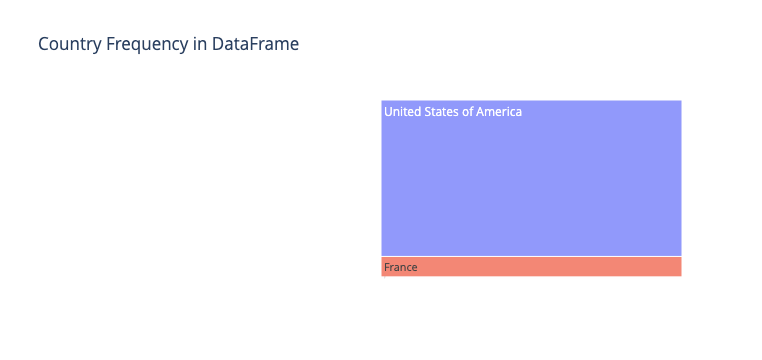

In [13]:
country_counts = df_merged['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Create the Icicle Chart
fig = px.icicle(country_counts, path=['Country'], values='Count', 
                title='Country Frequency in DataFrame')

# Show the chart
fig.show()

### Journal type

In [24]:
df_merged["Journal Type"].nunique()

83

### Earliest and latest date

In [43]:
df_merged['normalized_date'] =  pd.to_datetime(df_merged['normalized_date'])

In [44]:
df_merged['normalized_date'].min()

Timestamp('1801-12-22 00:00:00')

In [45]:
df_merged['normalized_date'].max()

Timestamp('2021-12-01 00:00:00')

In [16]:
df_merged.to_csv('/Users/carboni/Downloads/merged.csv', index=False)